In [1]:
import os
modelPath='/home/pi'
os.environ['PYTHONPATH'] = ':'+modelPath+'/models/research/:/root/models/research/slim/:' + modelPath +'/research/object_detection/utils/:'+modelPath+'/models/research/object_detection'

In [2]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

In [ ]:
%cd
!rm -rf tfdata
!git clone https://github.com/fllay/tfdata.git

In [ ]:
%cd
%cd /home/pi
!mkdir trained
!ls -l 

In [ ]:
%cd  /home/pi/models/research
!python3 object_detection/builders/model_builder_test.py

In [3]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [4]:
%cd /home/pi/tfdata

/home/pi/tfdata


In [5]:
xml_df=xml_to_csv('/home/pi/tfdata/images/train')
xml_df.to_csv('/home/pi/tfdata/data/train_labels.csv', index=None)
xml_df=xml_to_csv('/home/pi/tfdata/images/test')
xml_df.to_csv('/home/pi/tfdata/data/test_labels.csv', index=None)

In [6]:
!python3 generate_tfrecord.py --image_dir=/home/pi/tfdata/images/train --csv_input=/home/pi/tfdata/data/train_labels.csv  --output_path=/home/pi/tfdata/data/train.record

Successfully created the TFRecords: /home/pi/tfdata/data/train.record


In [7]:
!python3 generate_tfrecord.py --image_dir=/home/pi/tfdata/images/test --csv_input=/home/pi/tfdata/data/test_labels.csv  --output_path=/home/pi/tfdata/data/test.record

Successfully created the TFRecords: /home/pi/tfdata/data/test.record


In [8]:
%cd ~/tfdata
!rm -rf /home/pi/tfdata/pretrained_model/*
!rm -rf /home/pi/tfdata/trained/*

import os
import shutil
import glob
import urllib
import tarfile
from requests import get

#ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz

#MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18'
#MODEL = 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03'
#MODEL = 'ssdlite_mobilenet_v2_coco_2018_05_09'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

"""if not (os.path.exists(MODEL_FILE)):
  with open(MODEL_FILE, "wb") as file:
    # get request
    response = get(DOWNLOAD_BASE + MODEL_FILE)
    # write to file
    file.write(response.content)
    #opener = urllib.URLopener()
    #opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
"""
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

#os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/home/pi/tfdata


In [9]:
import tensorflow as tf
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

In [10]:
import os
os.environ['CONFIG_FILE'] = '/home/pi/tfdata/pipeline_mobilenet_v1_ssd_retrain_last_few_layers_edited.config'
#os.environ['CONFIG_FILE'] = '/home/pi/tfdata/pipeline_mobilenet_v2_ssd_retrain_last_few_layers_edited.config'
#os.environ['CONFIG_FILE'] = '/home/pi/tfdata/pipeline_mobilenet_v2_ssdlite_retrain_last_few_layers_edited.config'
someVariable = os.environ['CONFIG_FILE']
print(someVariable)



filename = '/home/pi/tfdata/pipeline_mobilenet_v1_ssd_retrain_last_few_layers.config'
#filename = '/home/pi/tfdata/pipeline_mobilenet_v2_ssd_retrain_last_few_layers.config'
#filename = '/home/pi/tfdata/pipeline_mobilenet_v2_ssdlite_retrain_last_few_layers.config'

filenameOut = os.environ['CONFIG_FILE']

pipeline_config = pipeline_pb2.TrainEvalPipelineConfig() 

with tf.gfile.GFile(filename, "r") as f:                                                                                                                                                                                                                     
  proto_str = f.read()                                                                                                                                                                                                                                          
  text_format.Merge(proto_str, pipeline_config)  


print(pipeline_config.eval_input_reader)
print(pipeline_config.train_input_reader)

pipeline_config.model.ssd.num_classes = 2
pipeline_config.train_config.fine_tune_checkpoint="/home/pi/tfdata/pretrained_model/model.ckpt"
pipeline_config.train_input_reader.label_map_path="/home/pi/tfdata/data/object-detection.pbtxt"
pipeline_config.train_input_reader.tf_record_input_reader.input_path[0]="/home/pi/tfdata/data/train.record" 
pipeline_config.eval_input_reader.label_map_path="/home/pi/tfdata/data/object-detection.pbtxt"
pipeline_config.eval_input_reader.tf_record_input_reader.input_path[0]="/home/pi/tfdata/data/test.record" 

pipeline_config.train_config.batch_size=2
pipeline_config.train_config.replicas_to_aggregate=2
#pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.manual_step_learning_rate.initial_learning_rate=0.00005


config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.gfile.Open(filenameOut, "wb") as f:                                                                                                                                                                                                                       
  f.write(config_text) 

/home/pi/tfdata/pipeline_mobilenet_v1_ssd_retrain_last_few_layers_edited.config
label_map_path: "DATASET_DIR_TO_CONFIGURE/pascal_label_map.pbtxt"
shuffle: false
num_readers: 1
tf_record_input_reader {
  input_path: "DATASET_DIR_TO_CONFIGURE/pascal_val.record"
}

label_map_path: "DATASET_DIR_TO_CONFIGURE/pascal_label_map.pbtxt"
tf_record_input_reader {
  input_path: "DATASET_DIR_TO_CONFIGURE/pascal_train.record"
}



In [11]:
!cat /home/pi/tfdata/pipeline_mobilenet_v1_ssd_retrain_last_few_layers_edited.config
#!cat /home/pi/tfdata/pipeline_mobilenet_v2_ssd_retrain_last_few_layers_edited.config
#!cat '/home/pi/tfdata/pipeline_mobilenet_v2_ssdlite_retrain_last_few_layers_edited.config'

model {
  ssd {
    num_classes: 2
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v1"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.99999989895e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.00999999977648
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.97000002861
          center: true
          scale: true
          epsilon: 0.0010000000475
        }
      }
      override_base_feature_extractor_hyperparams: true
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_thresh

In [12]:
%cd /home/pi/tfdata
!ls -l
!echo $CONFIG_FILE

/home/pi/tfdata
total 275020
-rw-rw-r-- 1 pi pi         9 พ.ค.   7 09:36 README.md
drwxrwxr-x 2 pi pi      4096 พ.ค.   7 10:28 data
drwxr-xr-x 3 pi pi      4096 พ.ค.  11 12:24 fine_tuned_model
-rw-rw-r-- 1 pi pi      3375 พ.ค.   7 09:36 generate_tfrecord.py
drwxrwxr-x 4 pi pi      4096 พ.ค.   7 09:36 images
-rw-rw-r-- 1 pi pi      5327 พ.ค.   7 09:36 pipeline_mobilenet_v1_ssd_retrain_last_few_layers.config
-rw-rw-r-- 1 pi pi      5447 พ.ค.  11 21:06 pipeline_mobilenet_v1_ssd_retrain_last_few_layers_edited.config
-rw-rw-r-- 1 pi pi      4710 พ.ค.   7 09:36 pipeline_mobilenet_v1_ssd_retrain_whole_model.config
-rw-rw-r-- 1 pi pi      5314 พ.ค.   7 09:36 pipeline_mobilenet_v2_ssd_retrain_last_few_layers.config
-rw-rw-r-- 1 pi pi      5447 พ.ค.  11 09:06 pipeline_mobilenet_v2_ssd_retrain_last_few_layers_edited.config
-rw-rw-r-- 1 pi pi      4778 พ.ค.   7 09:36 pipeline_mobilenet_v2_ssd_retrain_whole_model.config
-rw-rw-r-- 1 pi pi      5106 พ.ค.   7 09:36 pipeline_mobilenet_v2_ssdlite_retra

In [ ]:
!python3 ~/models/research/object_detection/legacy/train.py --logtostderr --fine_tune_batch_norm=False --train_dir=/home/pi/tfdata/trained/ --pipeline_config_path=$CONFIG_FILE

In [13]:
!python3 ~/models/research/object_detection/model_main.py \
    --pipeline_config_path=${CONFIG_FILE} \
    --model_dir=/home/pi/tfdata/trained \
    --alsologtostderr 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.
2019-05-11 21:08:42.104725: W tensorflow/core/platform/profile_utils/cpu_utils.cc:98] Failed to find bogomips in /proc/cpuinfo; cannot determine CPU frequency
2019-05-11 21:08:42.106252: I tensorflow/compiler/xla/service/service.cc:161] XLA service 0x21b6ec70 executing comput

In [14]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '/home/pi/tfdata/fine_tuned_model/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/home/pi/tfdata/data/object-detection.pbtxt'

In [15]:
%cd /home/pi/tfdata
!rm -rf /home/pi/tfdata/fine_tuned_model

lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')
print(last_model)

/home/pi/tfdata
model.ckpt-8407


In [16]:
!pwd
lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')
os.environ['last_model']=last_model

!python3 /home/pi/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=$CONFIG_FILE \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model

/home/pi/tfdata
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
114 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by          

In [17]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [18]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS)

In [19]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [20]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [21]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ '/home/pi/tfdata/images/test/image{}.jpg'.format(i) for i in range(1, 4) ]
for im in TEST_IMAGE_PATHS:
    print(im)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

/home/pi/tfdata/images/test/image1.jpg
/home/pi/tfdata/images/test/image2.jpg
/home/pi/tfdata/images/test/image3.jpg


In [22]:
# This is needed to display the images.
%matplotlib inline

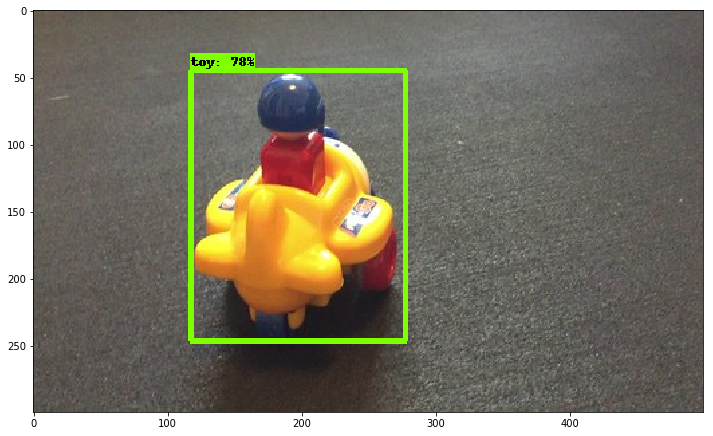

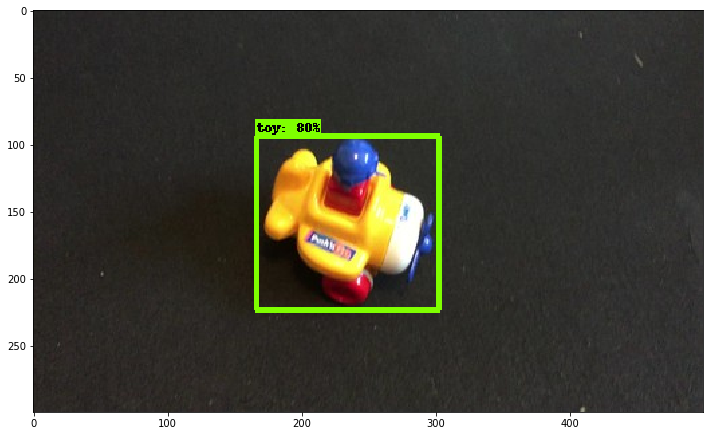

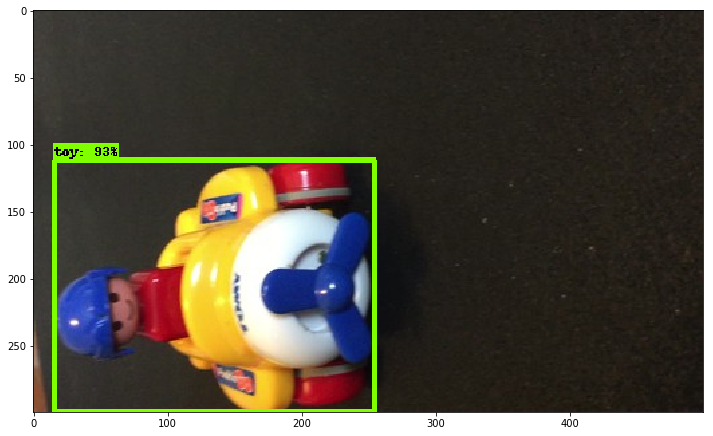

In [23]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  #print(output_dict['detection_scores'])
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)